In [34]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

In [73]:

# Each matlab file saves data in an object 'o', which has the following fields:
#     id: A unique alphanumeric identifier of the record
#     nS: Number of EEG data samples
#     sampFreq: Sampling frequency of the EEG data
#     marker: The eGUI [interaction record of the recording session]
#             0 --> Nothing displayed
#             1 --> Left hand
#             2 --> Right hand
#             3 --> Passive / neutral
#     data: The Raw [EEG data of the recording session]

# Returns DF with EEG data for each channe, as well as column for marker
def load_patient(file_path, keep_channels=None):
    raw = loadmat(file_path)['o']
    # Make sure sampFreq = 200
    # 200 hz --> period of 0.005 seconds
    assert(raw['sampFreq'][0][0][0][0] == 200)
    marker = pd.Series(raw['marker'][0][0].flatten())
    chnames = [elem[0][0] for elem in raw['chnames'][0][0]]
    data = raw['data'][0][0]
    df = pd.DataFrame(data, columns=chnames)
    if keep_channels != None:
        df = df.loc[:,keep_channels]
    return df, marker

In [219]:
# returns array of same len as marker, labeling each entry with membership to a specific
# trial, with a number from 0 - # trials
def trial_membership(marker, interval_lens):
    i = 0
    start = 0
    membership = np.full(shape=marker.shape, fill_value=-1)
    for test_instance in interval_lens:
        end = start + test_instance
        membership[start:end] = i
        i += 1
        start = end
    return membership

# keep_channels is a list of channels to keep.
# trial_len is the length of trial in seconds at which trials should be trimmed.  If a trial
# is shorter then trial_len, then results will be zero padded at all values after conclusion of that trial.
# returns (data, labels) where data is 3d array shape(trials, num_chans, num_observations)
# and labels 1d array of length trials, each entry corresponding to the label of trial in data at that index
def get_data(file_path, trial_len, keep_channels=None):
    patient, marker = load_patient("../data/CLASubjectA1601083StLRHand.mat", keep_channels)
    num_chans = patient.shape[1]

    # convert trial_len to num obvs at 200hz
    trim_len = int(trial_len / 0.005)
    
    # diff_mask is true at start of every new test condition
    diff_mask = (marker.diff(1) != 0)
    diffs = marker[diff_mask]

    start_indexes = pd.Series(diffs.index)
    interval_lens = start_indexes.diff(1)[1:].astype(int)
    # Add last interval to end
    interval_lens = interval_lens.append(pd.Series(len(marker) - start_indexes.iloc[-1]))

    # Because at beginning, long period of 0 --> Nothing displayed
    # so want everything to start with beginning of first trial
    labels = diffs.values[1:]
    marker = marker.values[interval_lens.values[0]:]
    patient = patient[interval_lens.values[0]:]
    # print("marker shape", marker.shape)

    interval_lens = interval_lens.values[1:]
    # print("int lens",interval_lens)


    # Because each trial has image displayed on screen for ~1 second,
    # and then a few seconds of blank screen where the patient is still
    # conducting the task, we want to combine the period where image shown
    # and the following blank screen
    non_zero_int_lens = interval_lens[labels != 0]
    zero_int_lens = interval_lens[labels == 0]
    labels = labels[labels != 0]
    interval_lens = non_zero_int_lens + zero_int_lens

    assert(labels.shape[0] == interval_lens.shape[0])

    membership = trial_membership(marker, interval_lens)
    
    # Format results as 3d array shape(trials, num_chans, num_observations)
    results = np.zeros(shape=(len(interval_lens), num_chans, trim_len))
    for i in range(0,len(interval_lens)):
        trial = patient[membership == i].values
        if trial.shape[0] > trim_len:
            trial = trial[:trim_len,:]
        results[i] = results[i] + trial.transpose()

    return (results, labels)

In [215]:
# TODO: Make trim intervals function to return ERP from the specified window
#       after stimulus is viewed
# def trim_intervals(data, start, length):
    

## Try to classify left and right hand actions with scikit learn SVM

1
(642, 1, 120)


Text(0, 0.5, 'ERP')

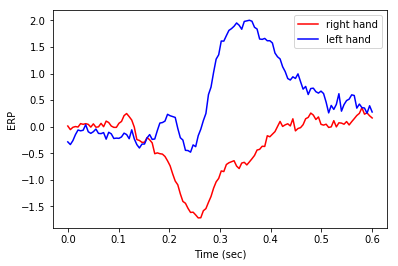

In [220]:
# keep_channels=['F3', 'C3', 'P3', 'T3']
# keep_channels=['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'A1', 'A2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
keep_channels=['C3']
print(len(keep_channels))
trial_len = 0.6

# X, y = get_data("../data/CLASubjectA1601083StLRHand.mat", trial_len, keep_channels)
X, y = get_data("../data/CLASubjectB1512153StLRHand.mat", trial_len, keep_channels)

X = X[y != 3]
y = y[y != 3]
# 0 is left hand
y[y == 1] = 0
# 1 is right hand
y[y == 2] = 1 
print(X.shape)
num_channels= len(keep_channels)
d2 = np.ceil(num_channels * trial_len/0.005).astype(int)
X = X.reshape(642, d2)
X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
seconds = np.linspace(0, trial_len, d2)
fig, ax = plt.subplots()
ax.plot(seconds, np.mean(X_train[y_train==1], axis=0), color="red", label="right hand")
ax.plot(seconds, np.mean(X_train[y_train==0], axis=0), color="blue", label="left hand")
ax.legend()
plt.xlabel("Time (sec)")
plt.ylabel("ERP")

In [221]:
C = np.linspace(1e-10, 40, 80)
params = {'C':C}
svc = SVC()
svc_gs = GridSearchCV(svc, params, cv=10, return_train_score=True, verbose=2, n_jobs=-1)
res = svc_gs.fit(X_train, y_train)
res1 = pd.DataFrame(res.cv_results_)
columns = ["param_C","mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]
res1.loc[:,columns]



Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   17.5s finished
/Users/d_berman/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/d_berman/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1e-10,0.524366,0.005021,0.524367,0.000558
1,0.506329,0.524366,0.005021,0.710197,0.017794
2,1.01266,0.619883,0.054101,1.000000,0.000000
3,1.51899,0.649123,0.044523,1.000000,0.000000
4,2.02532,0.649123,0.044523,1.000000,0.000000
5,2.53165,0.649123,0.044523,1.000000,0.000000
6,3.03797,0.649123,0.044523,1.000000,0.000000
7,3.5443,0.649123,0.044523,1.000000,0.000000
8,4.05063,0.649123,0.044523,1.000000,0.000000
9,4.55696,0.649123,0.044523,1.000000,0.000000
